In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import matplotlib.pyplot as plt

# **Load data**

In [4]:
df_papers = pd.read_csv("cleaned_final_data.csv", delimiter=',', on_bad_lines='skip')
df_patents = pd.read_csv("patents_labeled.csv")
df_fundings = pd.read_csv("quantum_funding_with_all_countries-2.csv", delimiter=';')


In [5]:
print(df_patents.columns)
print(df_fundings.columns)
print(df_papers.columns)

Index(['#', 'Publication Year', 'Title', 'Abstract', 'Applicants', 'Inventors',
       'Country', 'Label'],
      dtype='object')
Index(['year', 'Armenia', 'Austria', 'Belgium', 'Bulgaria', 'Switzerland',
       'Cyprus', 'Czech Republic', 'Germany', 'Denmark', 'Estonia', 'Greece',
       'Spain', 'Finland', 'France', 'Croatia', 'Hungary', 'Ireland', 'Israel',
       'Italy', 'Lithuania', 'Luxembourg', 'Latvia', 'Netherlands', 'Norway',
       'Poland', 'Portugal', 'Romania', 'Serbia', 'Sweden', 'Slovenia',
       'Slovakia', 'Turkey', 'Ukraine', 'United Kingdom', 'USA', 'Canada',
       'Japan', 'China', 'South Korea', 'India', 'Australia', 'Singapore'],
      dtype='object')
Index(['Authors', 'Title', 'Year', 'Cited by', 'Affiliations',
       'Authors with affiliations', 'Abstract', 'Author_list', 'Country',
       'Label'],
      dtype='object')


rename and extract the useful columns

In [6]:
# Clean papers
df_papers_clean = df_papers[['Year', 'Label', 'Country']].rename(columns={'Year': 'year', 'Label': 'label'})

# Clean patents
df_patents_clean = df_patents[['Publication Year', 'Label', 'Country']].rename(columns={'Publication Year': 'year', 'Label': 'label'})

# Melt funding data into long format: year, country, investment
df_funding_long = df_fundings.melt(id_vars=['year'], var_name='country', value_name='investment')

# Strip whitespace from all label values
df_papers_clean['label'] = df_papers_clean['label'].str.strip()
df_patents_clean['label'] = df_patents_clean['label'].str.strip()

# Drop invalid or missing labels
df_papers_clean = df_papers_clean[df_papers_clean['label'].notna()]
df_patents_clean = df_patents_clean[df_patents_clean['label'].notna()]


Aggregate data per year and label (topic), for each:

- Number of papers
- Number of patents
- Total public investment (summed across countries)

In [7]:
paper_counts = df_papers_clean.groupby(['year', 'label']).size().reset_index(name='paper_count')
patent_counts = df_patents_clean.groupby(['year', 'label']).size().reset_index(name='patent_count')

# this is for funding
# First, create a mapping of label -> countries for papers + patents
label_countries = pd.concat([df_papers_clean, df_patents_clean])[['year', 'label', 'Country']]
label_countries = label_countries.explode('Country') if label_countries['Country'].apply(lambda x: isinstance(x, list)).any() else label_countries
label_countries['Country'] = label_countries['Country'].str.strip()

label_countries = label_countries.rename(columns={'Country': 'country'})
funding_with_labels = pd.merge(label_countries, df_funding_long, on=['year', 'country'], how='left')

funding_per_topic = funding_with_labels.groupby(['year', 'label'])['investment'].sum().reset_index()


single datatset:

In [8]:
# Merge all
df_all = paper_counts.merge(patent_counts, on=['year', 'label'], how='outer')
df_all = df_all.merge(funding_per_topic, on=['year', 'label'], how='outer')

# Fill missing values (e.g. if a topic has no patents that year, or no funding)
df_all[['paper_count', 'patent_count', 'investment']] = df_all[['paper_count', 'patent_count', 'investment']].fillna(0)

df_all = df_all.rename(columns={'label': 'topic'})


In [9]:
df_all

,year,topic,paper_count,patent_count,investment
0,2017,error,0.0,1.0,0.0
1,2017,invalid_label,0.0,114.0,1200.0
2,2017,quantum algorithms,53.0,43.0,418.0
3,2017,quantum coherence,40.0,21.0,0.0
4,2017,quantum communication,23.0,68.0,200.0
...,...,...,...,...,...
356,2025,quantum state tomography,17.0,37.0,0.0
357,2025,quantum surface codes,1.0,7.0,0.0
358,2025,quantum thermodynamics,8.0,0.0,0.0
359,2025,quantum visualization tools,1.0,15.0,0.0


# **Predictions**

In [41]:
from sklearn.metrics import root_mean_squared_error
def train_and_predict(model, df_all, year_to_predict=2026, cv_folds=5, model_name="LinearRegression"):

    # 1. Filter
    df_train = df_all[df_all["year"] < year_to_predict].copy()
    X = df_train[["year", "patent_count", "investment"]]
    y = df_train["paper_count"]

    # 2. Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 3. Cross-val
    scores = cross_val_score(model, X_scaled, y, cv=cv_folds, scoring='r2')
    y_pred_cv = cross_val_predict(model, X_scaled, y, cv=cv_folds)
    #rmse = mean_squared_error(y, y_pred_cv, squared=False)
    rmse = root_mean_squared_error(y, y_pred_cv)
    mae = mean_absolute_error(y, y_pred_cv)

    print(f"[{model_name}] Cross-validated R² scores: {scores}")
    print(f"[{model_name}] Mean R²: {scores.mean():.4f}")
    print(f"[{model_name}] RMSE: {rmse:.2f}")
    print(f"[{model_name}] MAE: {mae:.2f}")

    # 4. Train model on all training data
    model.fit(X_scaled, y)

    # 5. Prepare future input (median features per topic)
    df_medians = df_all.groupby("topic").median(numeric_only=True).reset_index()
    df_medians["year"] = year_to_predict  # basically, simulate future year

    X_future = df_medians[["year", "patent_count", "investment"]]
    X_future_scaled = scaler.transform(X_future)
    df_medians["predicted_papers"] = model.predict(X_future_scaled)

    # 6. Results
    metrics = {
        "model": model_name,
        "mean_r2": scores.mean(),
        "rmse": rmse,
        "mae": mae
    }

    df_pred = df_medians[["topic", "predicted_papers"]].copy()
    return df_pred, metrics


In [42]:
results = []

## **Linear Regression**

In [44]:
df_pred_lr, metrics_lr = train_and_predict(LinearRegression(), df_all, model_name="LinearRegression")
results.append(metrics_lr)


[LinearRegression] Cross-validated R² scores: [-0.05278681  0.24836133  0.53857026  0.68509665  0.5351275 ]
[LinearRegression] Mean R²: 0.3909
[LinearRegression] RMSE: 81.86
[LinearRegression] MAE: 50.86


R² scores → one fold underfits (negative R²), but some are decent <br>
Mean R² → not amazing, but not random. linear captures someth. <br>
RMSE and MAE → moderate prediction error

The linear model is weak but not too bad, some nonlinear relationships exist.

## **Polynomial**

In [48]:
poly_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    StandardScaler(),
    Ridge(alpha=1.0)
)

df_pred_poly, metrics_poly = train_and_predict(poly_model, df_all, model_name="Polynomial (deg=2)")
results.append(metrics_poly)


[Polynomial (deg=2)] Cross-validated R² scores: [-0.01674106  0.35145279  0.56352608  0.68905457  0.55563128]
[Polynomial (deg=2)] Mean R²: 0.4286
[Polynomial (deg=2)] RMSE: 79.99
[Polynomial (deg=2)] MAE: 50.63


Slight improvement for all metrics (especially R² and RMSE). Some nonlinearity is being captured, still not amazing

degree 3...

In [49]:
poly_model = make_pipeline(
    PolynomialFeatures(degree=3, include_bias=False),
    StandardScaler(),
    Ridge(alpha=1.0)
)

df_pred_poly, metrics_poly = train_and_predict(poly_model, df_all, model_name="Polynomial (deg=3)")
results.append(metrics_poly)


[Polynomial (deg=3)] Cross-validated R² scores: [0.0472255  0.19060116 0.50047201 0.70651551 0.63076796]
[Polynomial (deg=3)] Mean R²: 0.4151
[Polynomial (deg=3)] RMSE: 79.06
[Polynomial (deg=3)] MAE: 48.11


not getting better

## **XGBoost** !!!!! I cannot run this, conflicts I couldn't solve !!!!

In [50]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)

df_pred_xgb, metrics_xgb = train_and_predict(xgb_model, df_all, model_name="XGBoost")
results.append(metrics_xgb)


[XGBoost] Cross-validated R² scores: [0.06488808 0.22108543 0.44858404 0.60345064 0.6290416 ]
[XGBoost] Mean R²: 0.3934
[XGBoost] RMSE: 84.26
[XGBoost] MAE: 51.70


## **Random Forest**

In [51]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
df_pred_rf, metrics_rf = train_and_predict(rf_model, df_all, model_name="RandomForest")
results.append(metrics_rf)

[RandomForest] Cross-validated R² scores: [0.13532483 0.26827414 0.48296902 0.64006541 0.52611394]
[RandomForest] Mean R²: 0.4105
[RandomForest] RMSE: 84.23
[RandomForest] MAE: 49.83


In [52]:
df_results = pd.DataFrame(results)
display(df_results)


,model,mean_r2,rmse,mae
0,LinearRegression,0.390874,81.863837,50.859922
1,LinearRegression,0.390874,81.863837,50.859922
2,Polynomial (deg=2),0.428585,79.990970,50.628723
3,Polynomial (deg=3),0.415116,79.062191,48.110232
4,XGBoost,0.393410,84.264960,51.702468
5,Polynomial (deg=2),0.428585,79.990970,50.628723
6,Polynomial (deg=3),0.415116,79.062191,48.110232
7,XGBoost,0.393410,84.264960,51.702468
8,RandomForest,0.410549,84.234731,49.833600


Polynomial still better in R² and RMSE. Random Forest has lowest MAE, indicating it's a bit better at small deviations from actual values. <br>
The models are all relatively close, suggesting the features (year, patent_count, investment) are informative but not perfect.

## **LightGBM**

In [53]:
hgb_model = HistGradientBoostingRegressor(max_iter=100, max_depth=5, learning_rate=0.1, random_state=42)

df_pred_hgb, metrics_hgb = train_and_predict(hgb_model, df_all, model_name="HistGradientBoosting")
results.append(metrics_hgb)


[HistGradientBoosting] Cross-validated R² scores: [0.1178108  0.20837085 0.49629298 0.39029414 0.42886979]
[HistGradientBoosting] Mean R²: 0.3283
[HistGradientBoosting] RMSE: 96.80
[HistGradientBoosting] MAE: 55.44


In [54]:
df_results = pd.DataFrame(results)
display(df_results)


,model,mean_r2,rmse,mae
0,LinearRegression,0.390874,81.863837,50.859922
1,LinearRegression,0.390874,81.863837,50.859922
2,Polynomial (deg=2),0.428585,79.990970,50.628723
3,Polynomial (deg=3),0.415116,79.062191,48.110232
4,XGBoost,0.393410,84.264960,51.702468
5,Polynomial (deg=2),0.428585,79.990970,50.628723
6,Polynomial (deg=3),0.415116,79.062191,48.110232
7,XGBoost,0.393410,84.264960,51.702468
8,RandomForest,0.410549,84.234731,49.833600
9,HistGradientBoosting,0.328328,96.801593,55.444801


## Some fine-tuning for the best model so far (deg 2)

In [55]:
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
results_ridge_poly = []

for alpha in alphas:
    model = make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        StandardScaler(),
        Ridge(alpha=alpha)
    )

    df_pred, metrics = train_and_predict(model, df_all, model_name=f"Poly (deg=2) + Ridge α={alpha}")
    results_ridge_poly.append(metrics)

results.extend(results_ridge_poly)

# Display
df_results = pd.DataFrame(results)
display(df_results)


[Poly (deg=2) + Ridge α=0.01] Cross-validated R² scores: [-0.01958085  0.34981973  0.55942927  0.67550097  0.55368396]
[Poly (deg=2) + Ridge α=0.01] Mean R²: 0.4238
[Poly (deg=2) + Ridge α=0.01] RMSE: 80.74
[Poly (deg=2) + Ridge α=0.01] MAE: 50.82
[Poly (deg=2) + Ridge α=0.1] Cross-validated R² scores: [-0.01953789  0.35003369  0.55990882  0.67694665  0.55386139]
[Poly (deg=2) + Ridge α=0.1] Mean R²: 0.4242
[Poly (deg=2) + Ridge α=0.1] RMSE: 80.66
[Poly (deg=2) + Ridge α=0.1] MAE: 50.80
[Poly (deg=2) + Ridge α=1.0] Cross-validated R² scores: [-0.01674106  0.35145279  0.56352608  0.68905457  0.55563128]
[Poly (deg=2) + Ridge α=1.0] Mean R²: 0.4286
[Poly (deg=2) + Ridge α=1.0] RMSE: 79.99
[Poly (deg=2) + Ridge α=1.0] MAE: 50.63
[Poly (deg=2) + Ridge α=10.0] Cross-validated R² scores: [0.04351539 0.34743918 0.56993707 0.73524024 0.56988986]
[Poly (deg=2) + Ridge α=10.0] Mean R²: 0.4532
[Poly (deg=2) + Ridge α=10.0] RMSE: 77.20
[Poly (deg=2) + Ridge α=10.0] MAE: 49.70
[Poly (deg=2) + Ridge

,model,mean_r2,rmse,mae
0,LinearRegression,0.390874,81.863837,50.859922
1,LinearRegression,0.390874,81.863837,50.859922
2,Polynomial (deg=2),0.428585,79.990970,50.628723
3,Polynomial (deg=3),0.415116,79.062191,48.110232
4,XGBoost,0.393410,84.264960,51.702468
5,Polynomial (deg=2),0.428585,79.990970,50.628723
6,Polynomial (deg=3),0.415116,79.062191,48.110232
7,XGBoost,0.393410,84.264960,51.702468
8,RandomForest,0.410549,84.234731,49.833600
9,HistGradientBoosting,0.328328,96.801593,55.444801


# **Predictions**

In [56]:
# Recreate best model
best_model = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    StandardScaler(),
    Ridge(alpha=10.0)
)

# Train and predict
df_pred_best, _ = train_and_predict(
    best_model,
    df_all,
    year_to_predict=2026,
    model_name="BestPolyRidge"
)

# Show top 10 topics by predicted paper count
df_top10 = df_pred_best.sort_values("predicted_papers", ascending=False).head(10)
display(df_top10[["topic", "predicted_papers"]])


[BestPolyRidge] Cross-validated R² scores: [0.04351539 0.34743918 0.56993707 0.73524024 0.56988986]
[BestPolyRidge] Mean R²: 0.4532
[BestPolyRidge] RMSE: 77.20
[BestPolyRidge] MAE: 49.70


,topic,predicted_papers
7,quantum computing,318.925737
8,quantum computing applications,282.384734
28,quantum optimization,248.747318
21,quantum hardware,237.085118
32,quantum sensing,224.004771
10,quantum computing hardware (hybrid),174.548589
31,quantum security tools,129.111740
13,quantum control,121.456773
15,quantum cryptography,115.200264
1,invalid_label,93.185419


# Plot...

here it was a try... does not make sense to print them all, but I wanted to see what came out. i eliminated 2025 from the plot because it doesn't show a real thing, it is too ealry to include thosse data probably

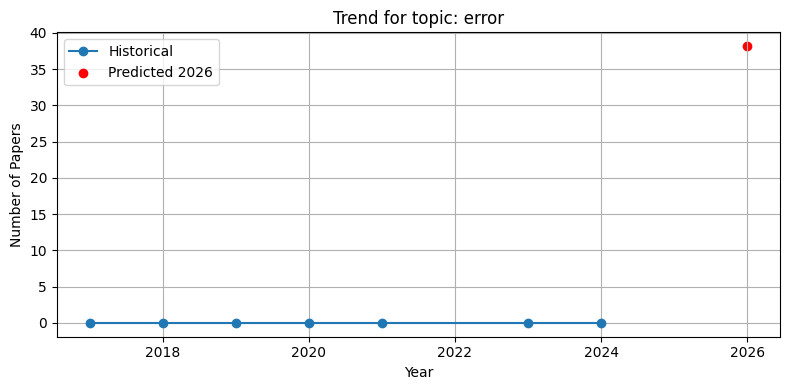

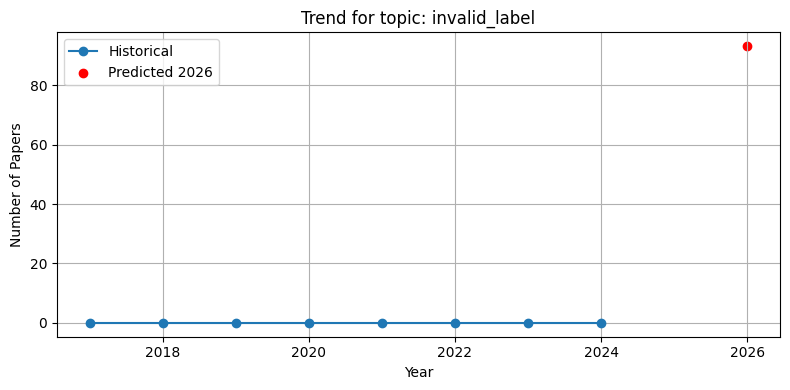

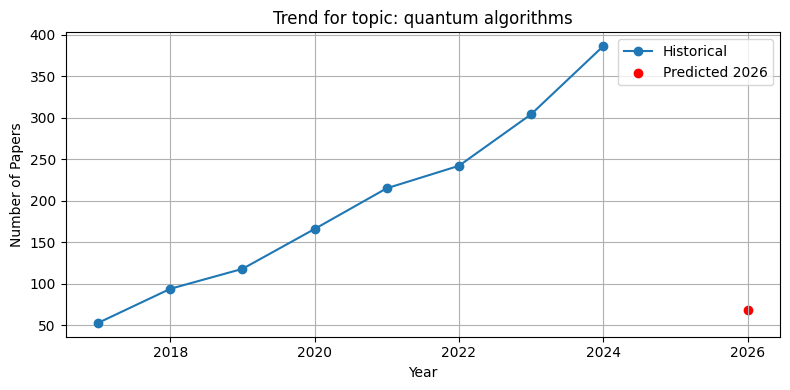

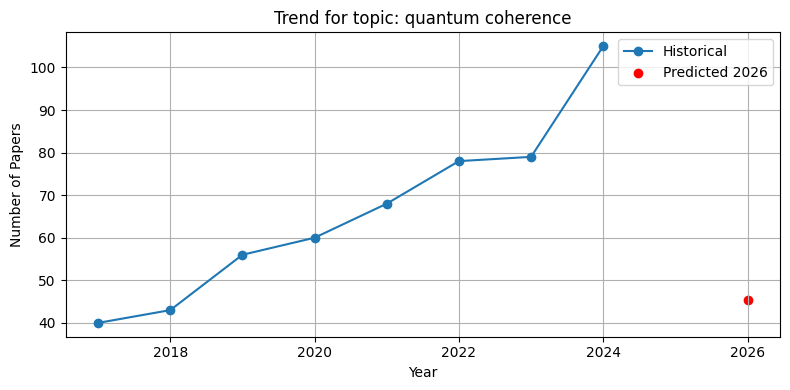

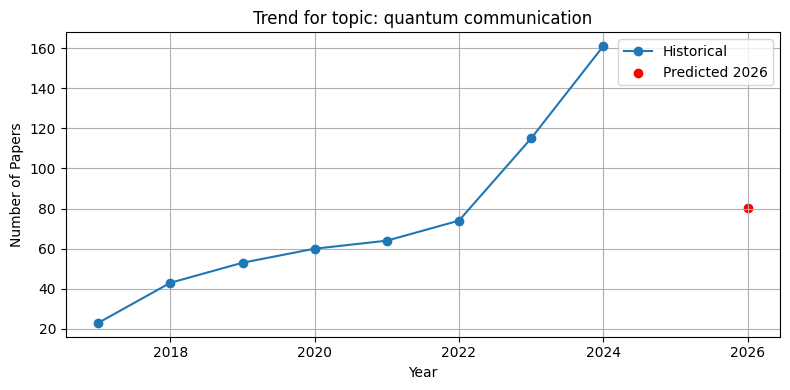

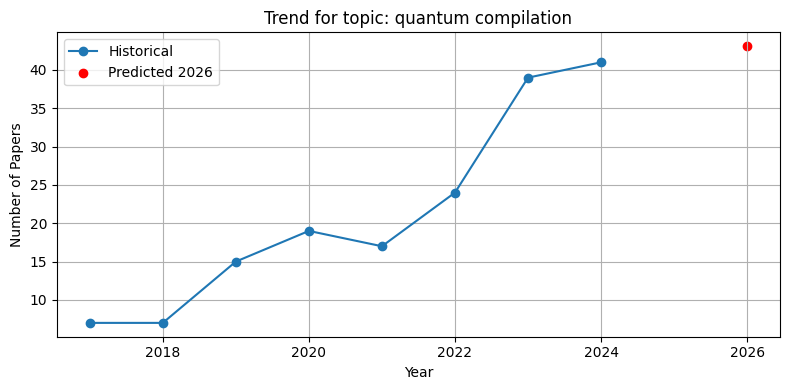

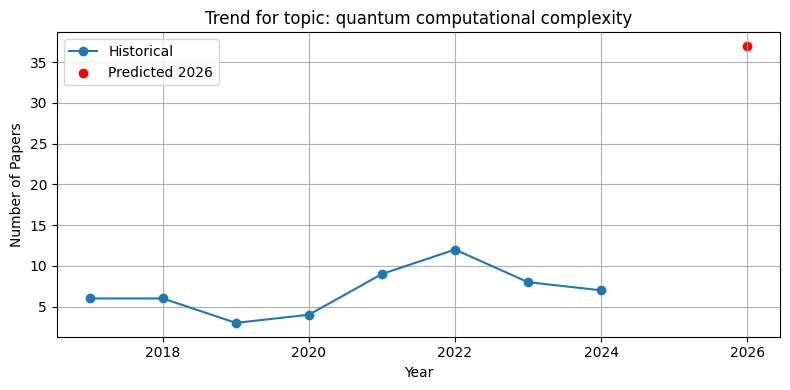

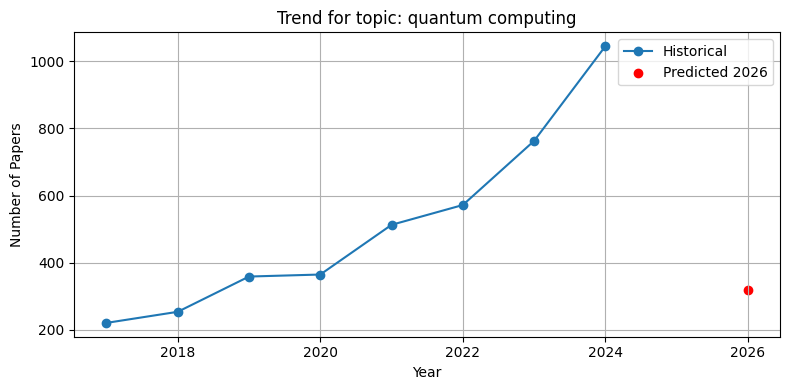

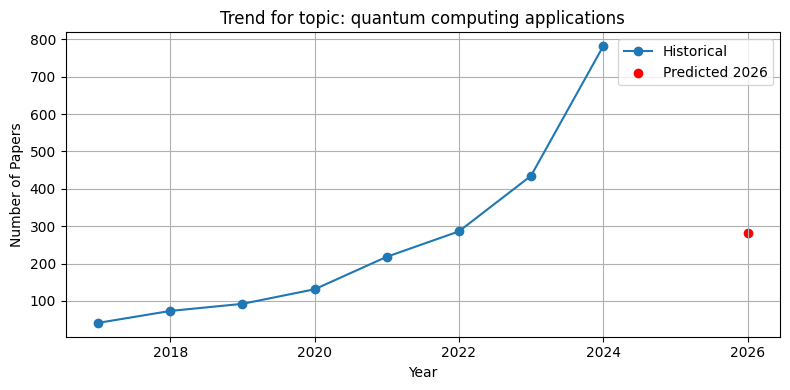

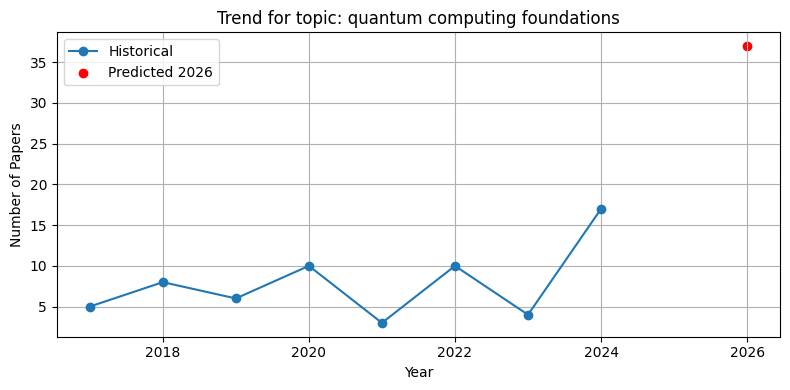

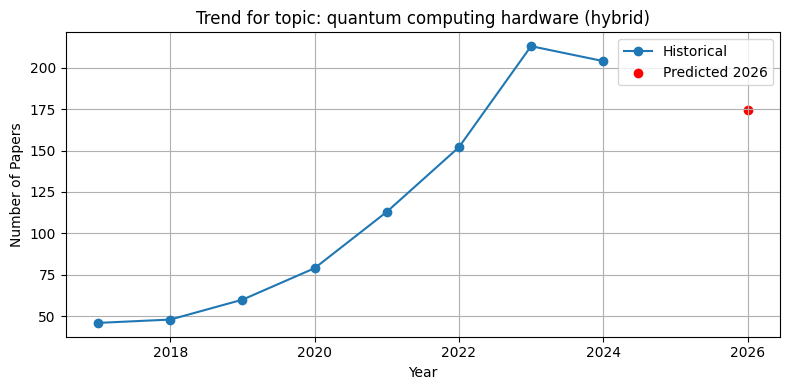

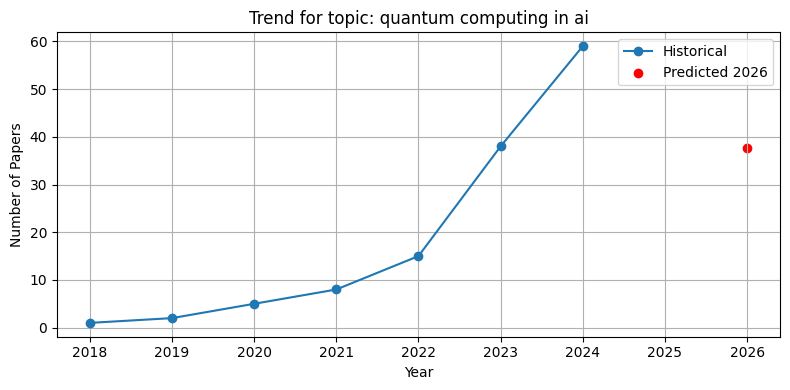

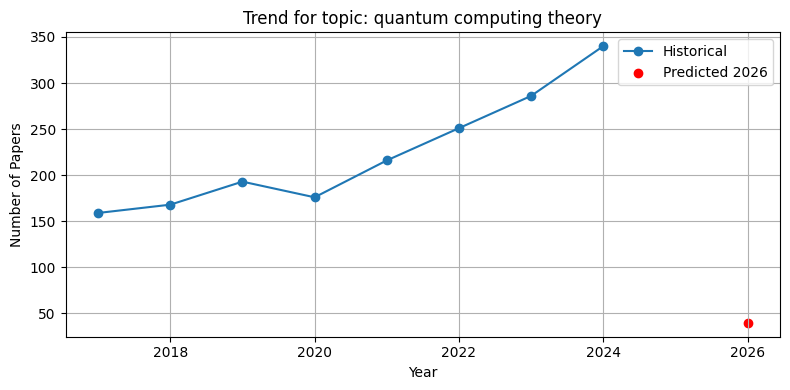

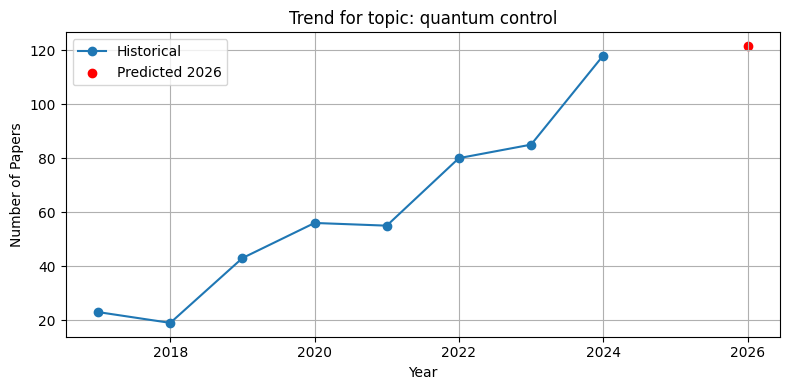

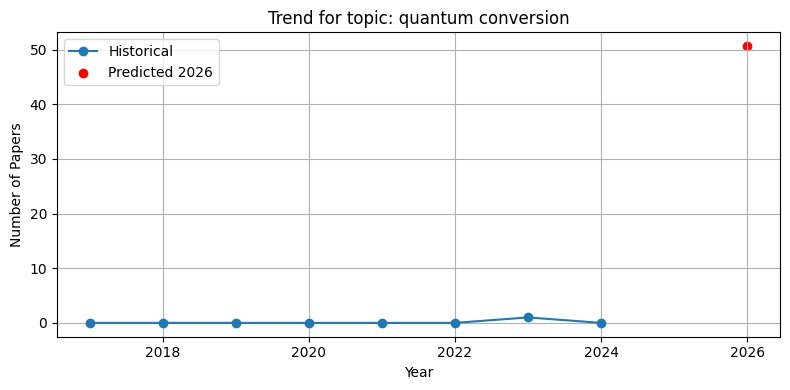

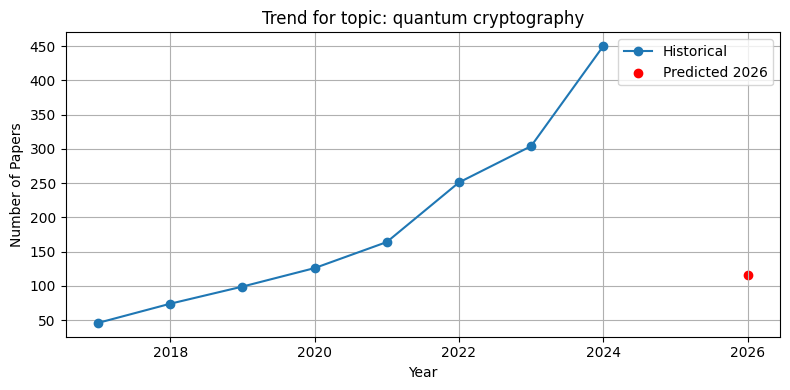

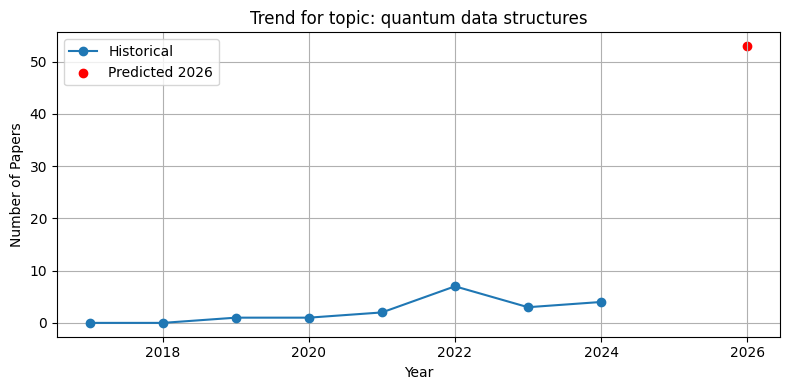

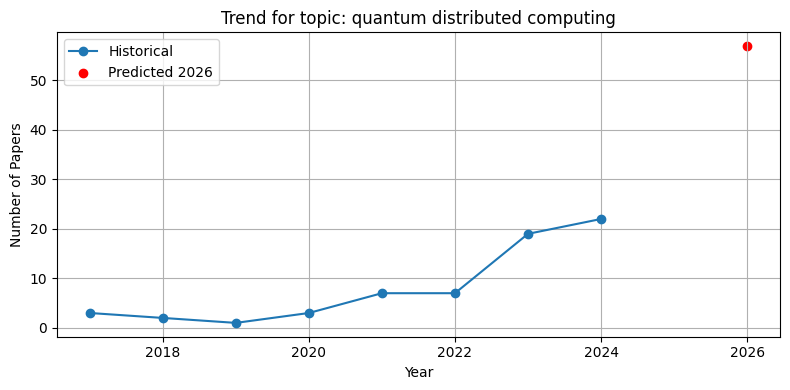

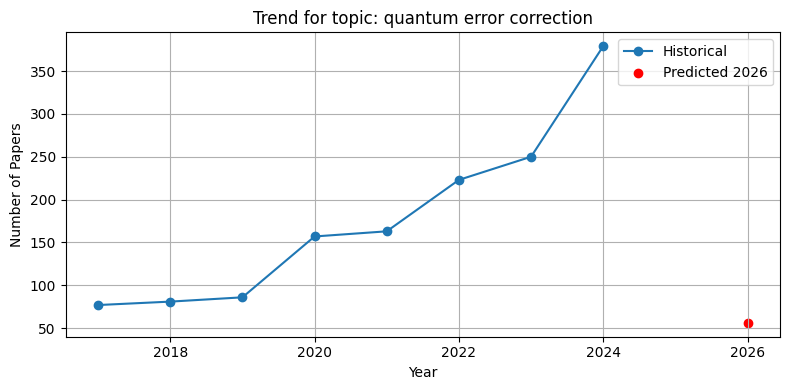

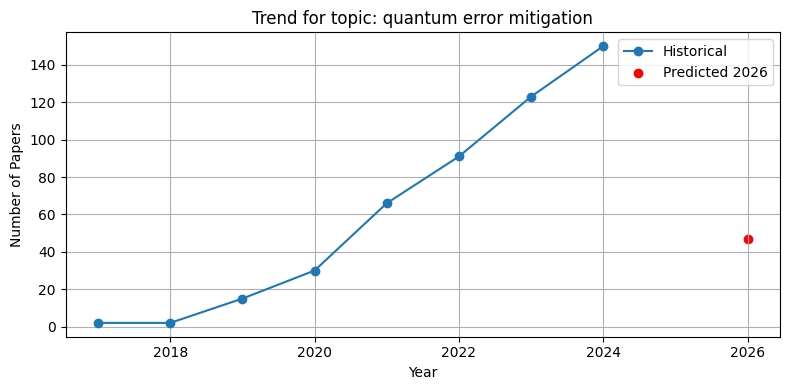

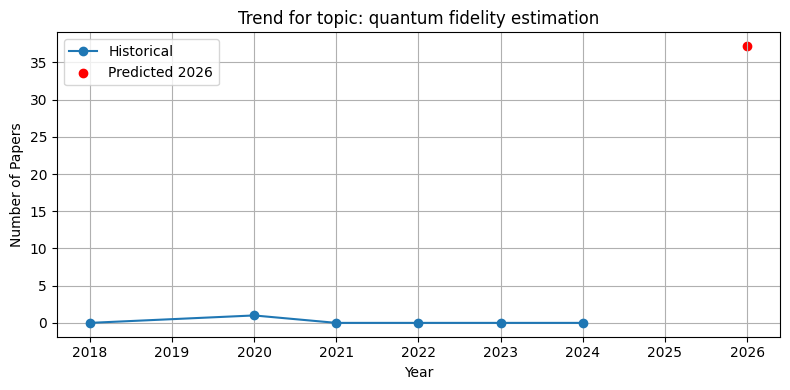

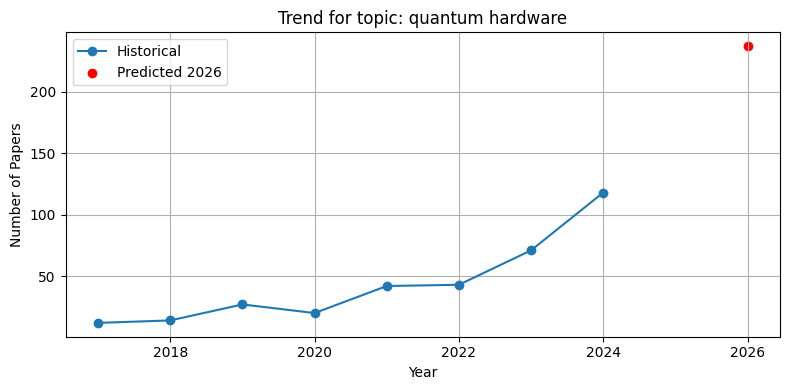

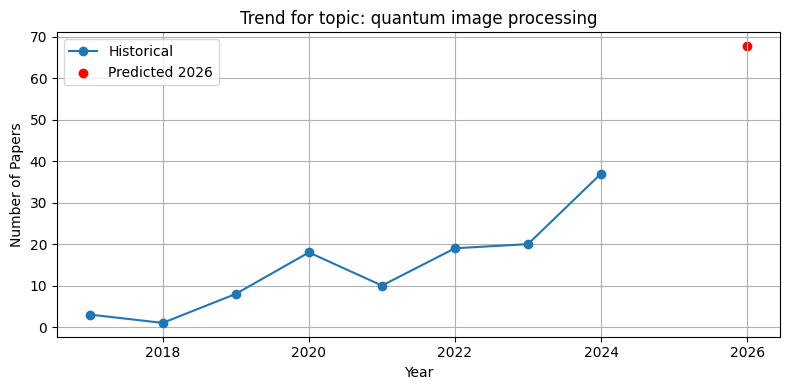

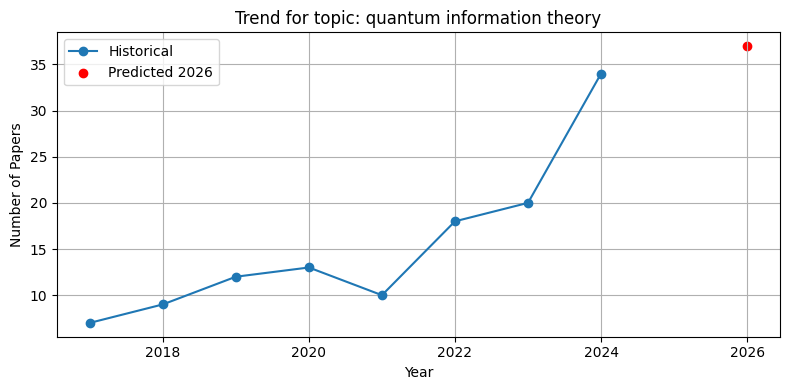

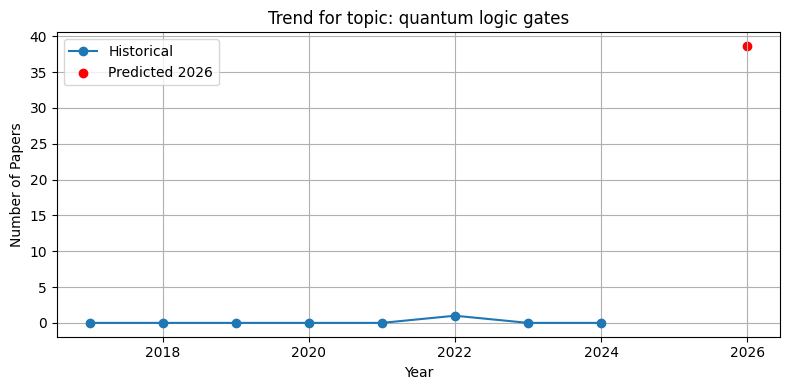

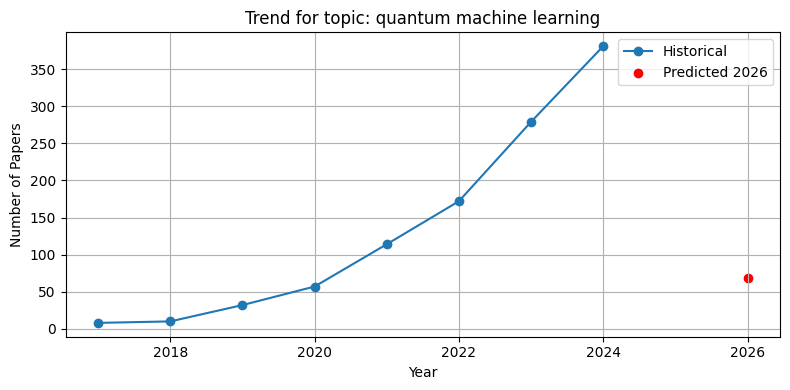

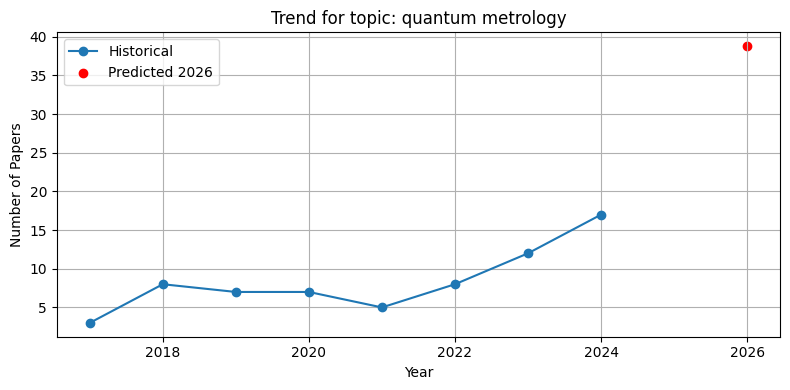

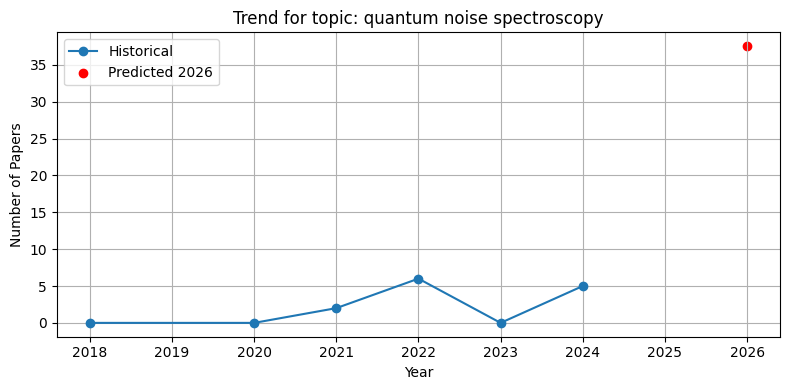

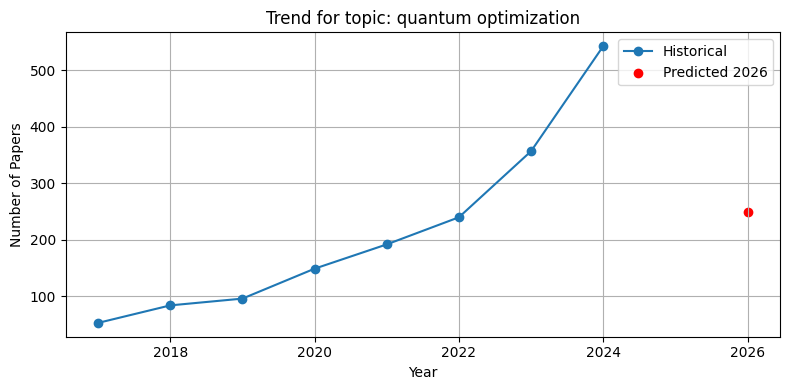

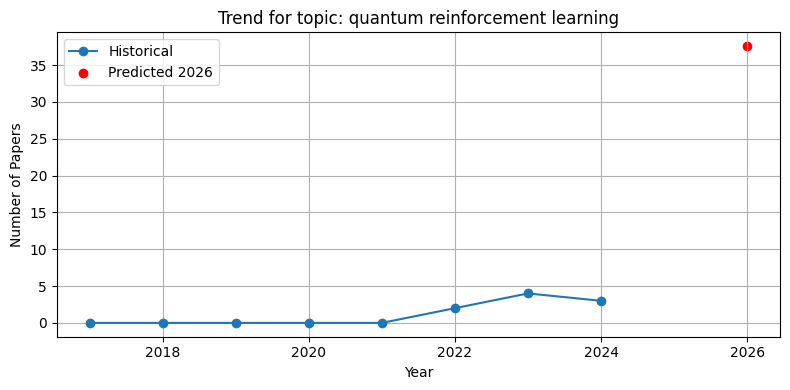

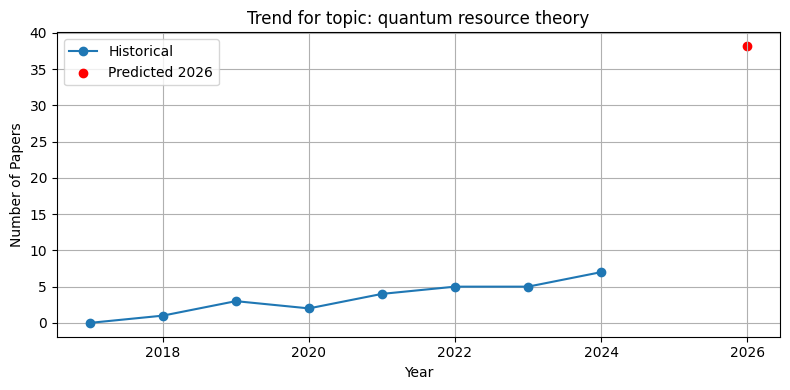

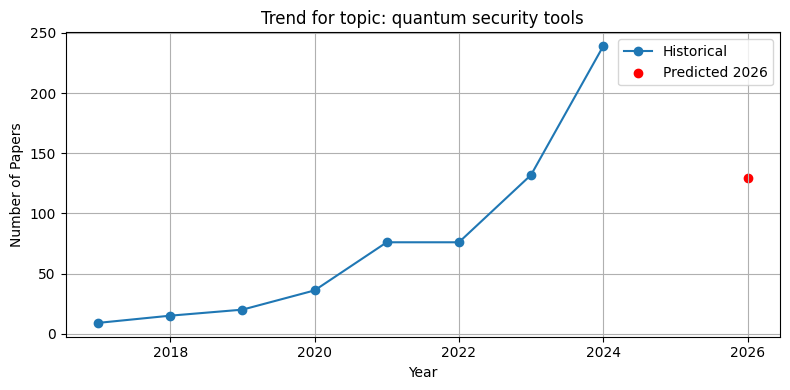

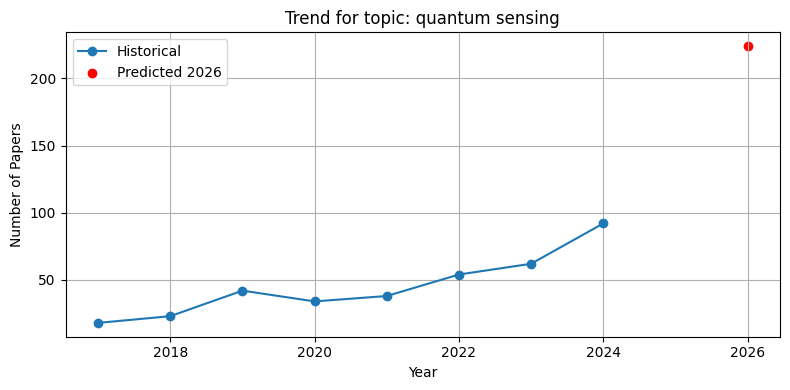

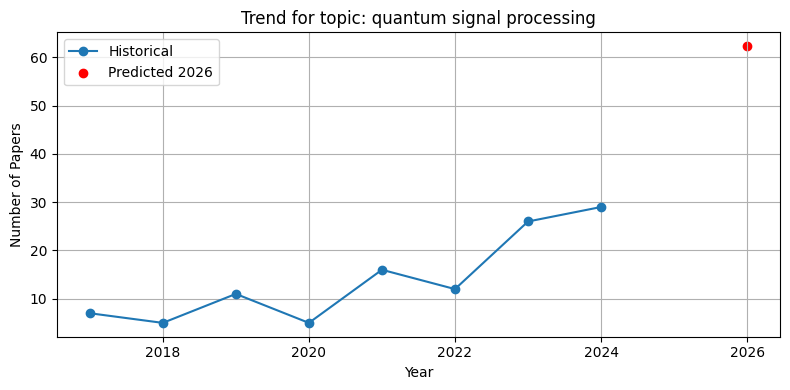

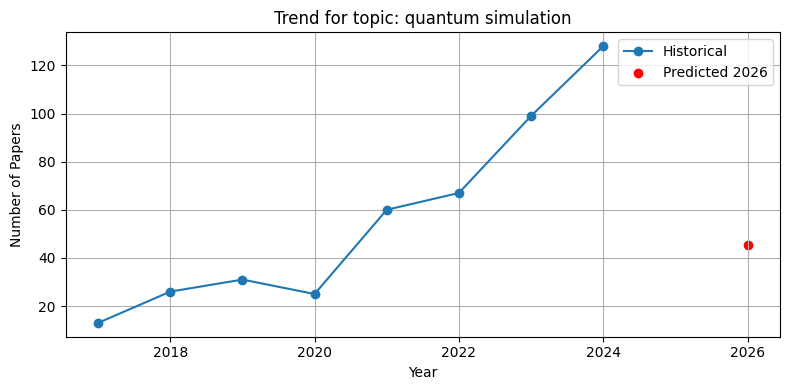

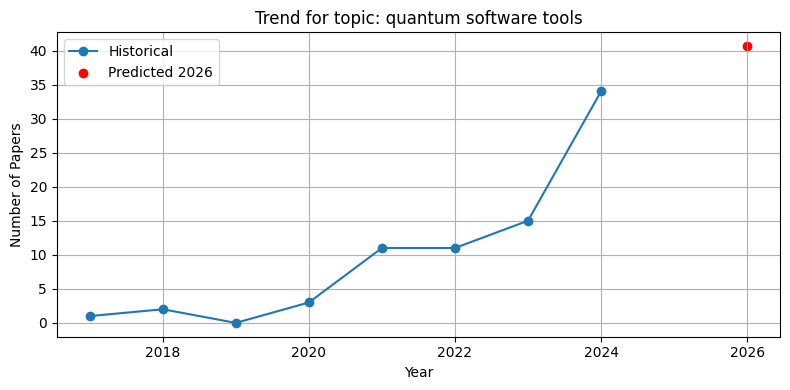

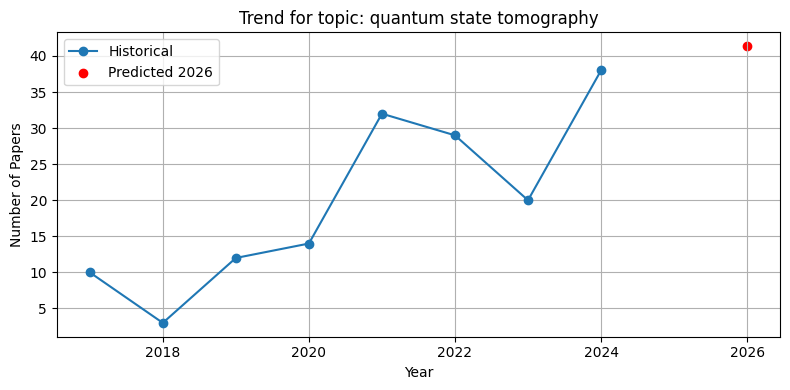

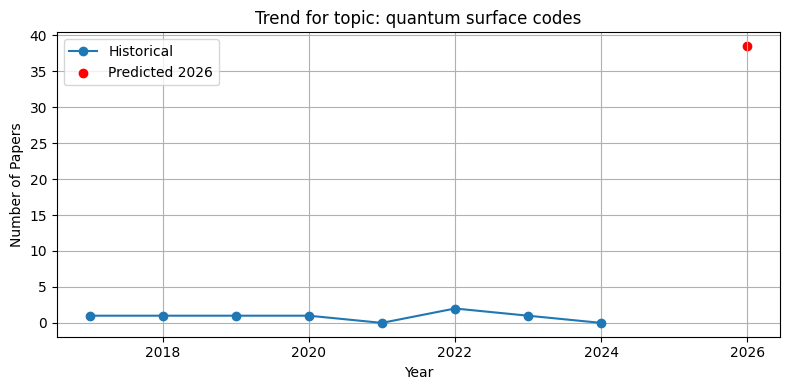

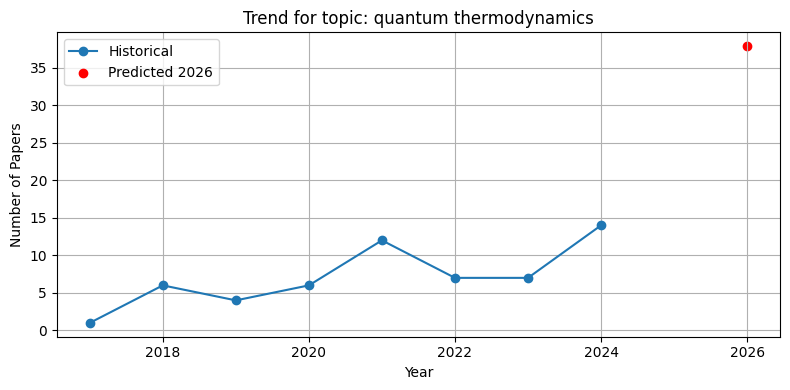

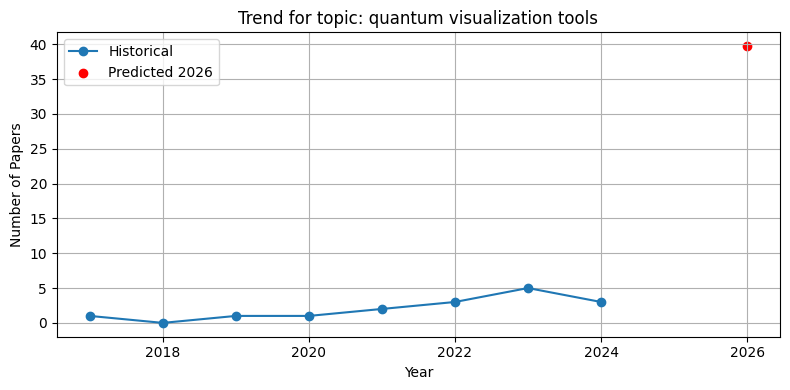

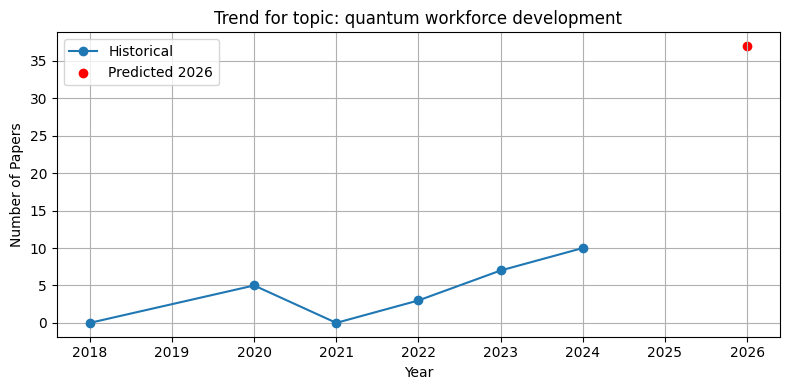

In [57]:
for _, row in df_pred_best.iterrows():
    topic = row["topic"]
    predicted_value = row["predicted_papers"]

    # Historical data for that topic (excluding 2025)
    df_topic = df_all[(df_all["topic"] == topic) & (df_all["year"] < 2025)].sort_values("year")

    plt.figure(figsize=(8, 4))
    plt.plot(df_topic["year"], df_topic["paper_count"], marker='o', label="Historical")
    plt.scatter(2026, predicted_value, color="red", label="Predicted 2026")

    plt.title(f"Trend for topic: {topic}")
    plt.xlabel("Year")
    plt.ylabel("Number of Papers")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    plt.show()
